In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from utils import color_df
from mlxtend.frequent_patterns import apriori
from scipy import stats
import statsmodels.api as sm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from utils import color_df, hopkins_test

In [2]:
# Dowlaad the data from github repo 
df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv')
df.sample(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
17,Gobstopper,0,1,0,0,0,0,1,0,1,0.906,0.453,46.783348
10,Charleston Chew,1,0,0,0,1,0,0,1,0,0.604,0.511,38.975037
27,Junior Mints,1,0,0,0,0,0,0,0,1,0.197,0.511,57.219250
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
73,Swedish Fish,0,1,0,0,0,0,0,0,1,0.604,0.755,54.861111
55,Ring pop,0,1,0,0,0,0,1,0,0,0.732,0.965,35.290756
59,Sixlets,1,0,0,0,0,0,0,0,1,0.220,0.081,34.722000
78,Trolli Sour Bites,0,1,0,0,0,0,0,0,1,0.313,0.255,47.173229
44,Nik L Nip,0,1,0,0,0,0,0,0,1,0.197,0.976,22.445341


### The data contains the following fields:

For binary variables, 1 means yes, 0 means no.


Header | Description
-------|------------
chocolate | Does it contain chocolate?
fruity | Is it fruit flavored?
caramel | Is there caramel in the candy?
peanutalmondy | Does it contain peanuts, peanut butter or almonds?
nougat | Does it contain nougat?
crispedricewafer | Does it contain crisped rice, wafers, or a cookie component?
hard | Is it a hard candy?
bar | Is it a candy bar?
pluribus | Is it one of many candies in a bag or box?
sugarpercent | The percentile of sugar it falls under within the data set.
pricepercent | The unit price percentile compared to the rest of the set.
winpercent | The overall win percentage according to 269,000 matchups.


In [3]:
# Getting a glimpse of the dataset as well as checking for missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [4]:
# Overview about the descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
chocolate,85.0,0.435294,0.498738,0.000000,0.000000,0.000000,1.000000,1.00000
fruity,85.0,0.447059,0.500140,0.000000,0.000000,0.000000,1.000000,1.00000
caramel,85.0,0.164706,0.373116,0.000000,0.000000,0.000000,0.000000,1.00000
peanutyalmondy,85.0,0.164706,0.373116,0.000000,0.000000,0.000000,0.000000,1.00000
nougat,85.0,0.082353,0.276533,0.000000,0.000000,0.000000,0.000000,1.00000
crispedricewafer,85.0,0.082353,0.276533,0.000000,0.000000,0.000000,0.000000,1.00000
hard,85.0,0.176471,0.383482,0.000000,0.000000,0.000000,0.000000,1.00000
bar,85.0,0.247059,0.433861,0.000000,0.000000,0.000000,0.000000,1.00000
pluribus,85.0,0.517647,0.502654,0.000000,0.000000,1.000000,1.000000,1.00000
sugarpercent,85.0,0.478647,0.282778,0.011000,0.220000,0.465000,0.732000,0.98800


## Feature Engineering

In [5]:
# Clean the letter Õ
df['competitorname'] = df['competitorname'].str.replace('Õ', "")

In [6]:
# Div Winpercent by 100 to have it in the same scale as the other two percentage variables 
df['winpercent'] = round(df['winpercent']/100, 3)
table = df.head(10) 
table.set_index("competitorname").style.applymap(color_df)

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
competitorname,,,,,,,,,,,,
100 Grand,1,0,1,0,0,1,0,1,0,0.732000,0.860000,0.670000
3 Musketeers,1,0,0,0,1,0,0,1,0,0.604000,0.511000,0.676000
One dime,0,0,0,0,0,0,0,0,0,0.011000,0.116000,0.323000
One quarter,0,0,0,0,0,0,0,0,0,0.011000,0.511000,0.461000
Air Heads,0,1,0,0,0,0,0,0,0,0.906000,0.511000,0.523000
Almond Joy,1,0,0,1,0,0,0,1,0,0.465000,0.767000,0.503000
Baby Ruth,1,0,1,1,1,0,0,1,0,0.604000,0.767000,0.569000
Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313000,0.511000,0.234000
Candy Corn,0,0,0,0,0,0,0,0,1,0.906000,0.325000,0.380000


In [7]:
# Combine the two variables
# Higher value -> the candy is sweet as well as cheap.
### df['sugarbyprice'] = round(df['sugarpercent'].div(df['pricepercent']), 3) 

# Higher value -> the candy is more liked as well as cheap.
### df['winbyprice'] = round(df['winpercent'].div(df['pricepercent']), 3) 

# Check the transformations 
### df.sample(5)

# EDA

All the most fav candies contain choccolate, none of them are either fruity or hard. Perhaps, penaut or almond helps in be liked by people. Also, interesting to see there are not one of many candies in the box. 

In [66]:
# Most fav candies 
table = df.sort_values('winpercent', ascending=False).head(10)
table.set_index("competitorname").style.applymap(color_df)

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
competitorname,,,,,,,,,,,,
Reeses Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720000,0.651000,0.842000
Reeses Miniatures,1,0,0,1,0,0,0,0,0,0.034000,0.279000,0.819000
Twix,1,0,1,0,0,1,0,1,0,0.546000,0.906000,0.816000
Kit Kat,1,0,0,0,0,1,0,1,0,0.313000,0.511000,0.768000
Snickers,1,0,1,1,1,0,0,1,0,0.546000,0.651000,0.767000
Reeses pieces,1,0,0,1,0,0,0,0,1,0.406000,0.651000,0.734000
Milky Way,1,0,1,0,1,0,0,1,0,0.604000,0.651000,0.731000
Reeses stuffed with pieces,1,0,0,1,0,0,0,0,0,0.988000,0.651000,0.729000
Peanut butter M&Ms,1,0,0,1,0,0,0,0,1,0.825000,0.651000,0.715000


In [9]:
# Least fav candies 
df.sort_values('winpercent', ascending=False).tail(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
19,Haribo Happy Cola,0,0,0,0,0,0,0,0,1,0.465,0.465,0.342
70,Sugar Babies,0,0,1,0,0,0,0,0,1,0.965,0.767,0.334
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.323
71,Sugar Daddy,0,0,1,0,0,0,0,0,0,0.418,0.325,0.322
57,Root Beer Barrels,0,0,0,0,0,0,1,0,1,0.732,0.069,0.297
26,Jawbusters,0,1,0,0,0,0,1,0,1,0.093,0.511,0.281
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,0.273
12,Chiclets,0,1,0,0,0,0,0,0,1,0.046,0.325,0.245
7,Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313,0.511,0.234
44,Nik L Nip,0,1,0,0,0,0,0,0,1,0.197,0.976,0.224


If we sort by price the game changes a lot, here the most fav candies can be either chocco or fruity. Probably, plays a good part the fact that you get many of them in one box for cheap, compared to the other case.  

In [10]:
#df.sort_values('winbyprice', ascending=False).head(10)

Analyzing the candy components and some possible combinations

In [11]:
print(f"N of choco and fruity {len(df[(df['chocolate']==1)&(df['fruity']==1)])}")
print(f"N of choco and peanutyalmondy {len(df[(df['chocolate']==1)&(df['peanutyalmondy']==1)])}")
print(f"N of choco and pluribus {len(df[(df['chocolate']==1)&(df['pluribus']==1)])}")
print(f"N of choco candies {len(df[df['chocolate']==1])}")
print(f"N of fruity {len(df[df['fruity']==1])}")

N of choco and fruity 1
N of choco and peanutyalmondy 12
N of choco and pluribus 12
N of choco candies 37
N of fruity 38


In [12]:
# This is a good combo but also quite expansive
df[(df['chocolate']==1)&(df['pluribus']==1)].sort_values('winpercent', ascending=False)[:5]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
53,Reeses pieces,1,0,0,1,0,0,0,0,1,0.406,0.651,0.734
32,Peanut butter M&Ms,1,0,0,1,0,0,0,0,1,0.825,0.651,0.715
47,Peanut M&Ms,1,0,0,1,0,0,0,0,1,0.593,0.651,0.695
33,M&Ms,1,0,0,0,0,0,0,0,1,0.825,0.651,0.666
56,Rolo,1,0,1,0,0,0,0,0,1,0.860,0.860,0.657


In [13]:
# Which is the one with both choco and fruit? 
df[(df['chocolate']==1)&(df['fruity']==1)]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
74,Tootsie Pop,1,1,0,0,0,0,1,0,0,0.604,0.325,0.49


Check perc yes/no for categorical values

In [14]:
for cat_val in df[df.columns[1:-5]]: 
    print(cat_val)
    print(df[cat_val].value_counts(normalize = True)*100)
    print()

chocolate
0    56.470588
1    43.529412
Name: chocolate, dtype: float64

fruity
0    55.294118
1    44.705882
Name: fruity, dtype: float64

caramel
0    83.529412
1    16.470588
Name: caramel, dtype: float64

peanutyalmondy
0    83.529412
1    16.470588
Name: peanutyalmondy, dtype: float64

nougat
0    91.764706
1     8.235294
Name: nougat, dtype: float64

crispedricewafer
0    91.764706
1     8.235294
Name: crispedricewafer, dtype: float64

hard
0    82.352941
1    17.647059
Name: hard, dtype: float64



### Pearson Corr

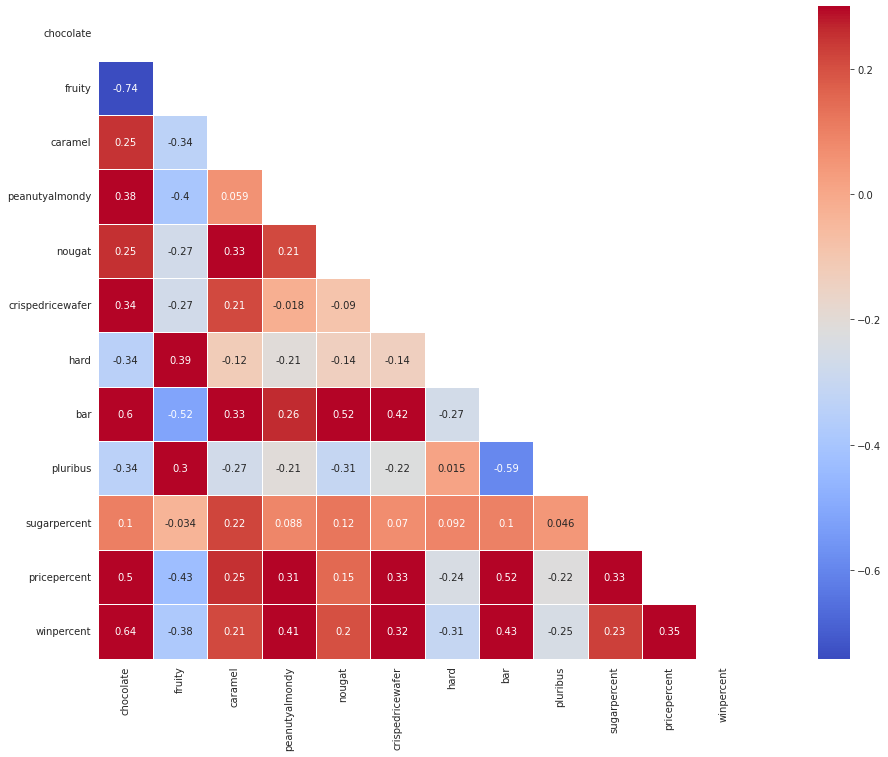

In [15]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(24, 12))
    ax = sns.heatmap(df.corr(), mask=mask, vmax=.3, square=True, annot=True, cmap = 'coolwarm', linewidths=.5)

There's multicollinearity we'll adress with PCA. Chocolate is the most corr with winpercent, also with price perc though. We need to find a good combo to keep the price low and use chocolate. 

### Spearman Corr

In [16]:
print("winpercent vs sugar percent {}".format(stats.spearmanr(df.winpercent, df.sugarpercent)))
print("winpercent vs price percent {}".format(stats.spearmanr(df.winpercent, df.pricepercent)))

winpercent vs sugar percent SpearmanrResult(correlation=0.21917627188619349, pvalue=0.04386672037824133)
winpercent vs price percent SpearmanrResult(correlation=0.3546312501902001, pvalue=0.0008682735199554266)


### Apriori Algo

<AxesSubplot:title={'center':'Most Frequent Combination by Top Candies'}, ylabel='itemsets'>

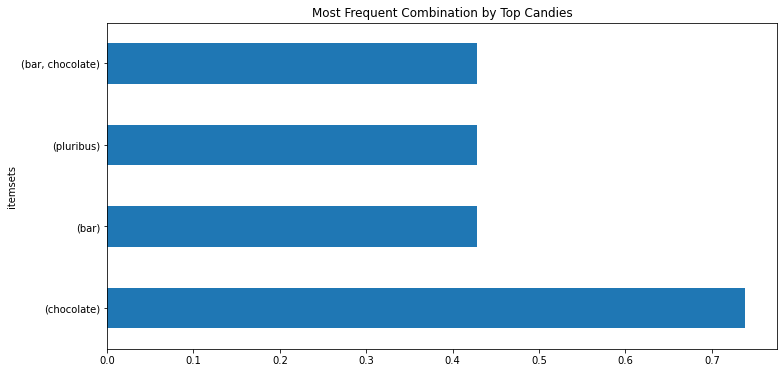

In [17]:
# filter candies greater than 
bests = df[df['winpercent']>df['winpercent'].quantile(.5)]
df_bests =  bests[df.columns[1:-3]]

# use apriori alg with min support .4
result = apriori(df_bests, min_support=0.4,use_colnames=True).sort_values(by='support', ascending=False)

# plot as a bar chart
result.plot(kind='barh',x='itemsets',y='support',title=f'Most Frequent Combination by Top Candies',
                 sort_columns=True,figsize = (12,6),legend=False)

<AxesSubplot:xlabel='fruity', ylabel='winpercent'>

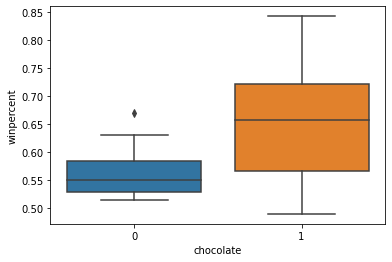

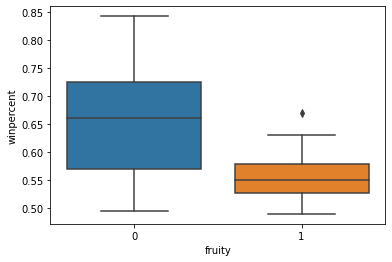

In [18]:
plt.subplot2grid
plt.figure(figsize=(6, 4))
sns.boxplot(x="chocolate", y="winpercent", data=bests)
plt.figure(figsize=(6, 4))
sns.boxplot(x="fruity", y="winpercent", data=bests)

In [19]:
df.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')

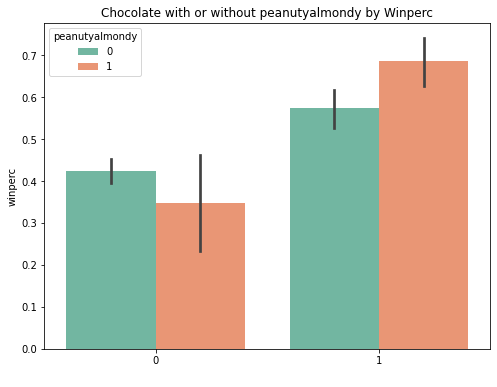

In [20]:
#set a empty canva where to put the bargrahp 
fig, ax = plt.subplots()

#create the bargraphs by player's race
sns.barplot(data = df, 
            x = "chocolate", 
            y = "winpercent", 
            hue = "peanutyalmondy",  palette="Set2")

#Set title and labels for the axis 
plt.title("Chocolate with or without peanutyalmondy by Winperc")
plt.xlabel(" ")
plt.ylabel("winperc")

#set the graph's size
fig.set_size_inches(8, 6)

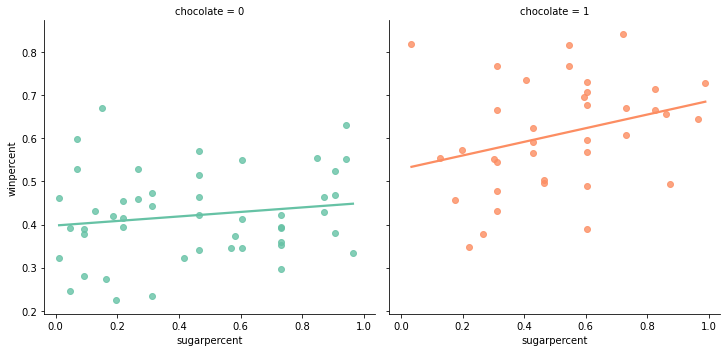

In [21]:
#Scatter plot with a regression line 
sns.lmplot(x = "sugarpercent", y = "winpercent", data = df, 
           hue= "chocolate", col = "chocolate", col_wrap=3, 
           palette="Set2", ci = None)

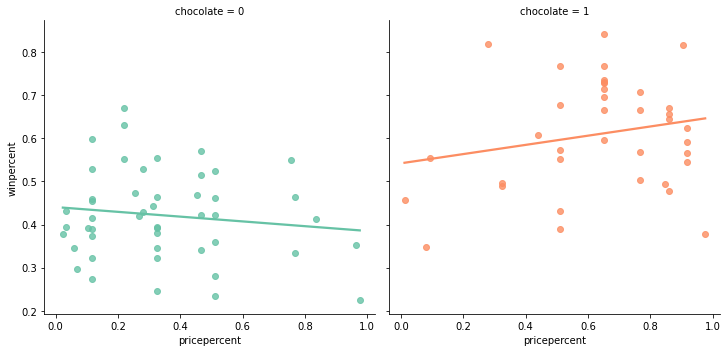

In [22]:
#Scatter plot with a regression line 
sns.lmplot(x = "pricepercent", y = "winpercent", data = df, 
           hue= "chocolate", col = "chocolate", col_wrap=3, 
           palette="Set2", ci = None)

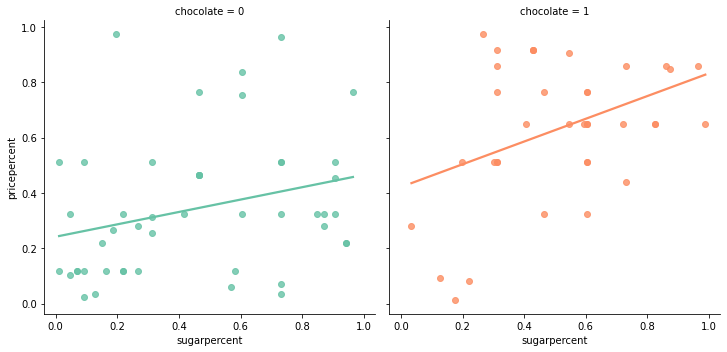

In [23]:
#Scatter plot with a regression line 
sns.lmplot(x = "sugarpercent", y = "pricepercent", data = df, 
           hue= "chocolate", col = "chocolate", col_wrap=3, 
           palette="Set2", ci = None)

Of course if the price increase the winperent is lower, compared if the sugar increase. Though, with chocolate, the slope it still positive. Also, more sugar means higher price. Perhaps, a choco candy with less sugar might be a good starting point. Howver, there are lots of the in the market already. 

In [24]:
no_choco_no_alm = df[(df["chocolate"] == 0) & (df["peanutyalmondy"] == 0)]["winpercent"]

print(f"No choco no alm candy average winperc: {np.mean(no_choco_no_alm)}")

with_choco_alm = df[(df["chocolate"] == 1) & (df["peanutyalmondy"] == 1)]["winpercent"]

print(f"Choco and alm candy average winperc: {np.mean(with_choco_alm)}")

with_choco_no_alm = df[(df["chocolate"] == 1) & (df["peanutyalmondy"] == 0)]["winpercent"]

print(f"With Choco and no alm candy average winperc: {np.mean(with_choco_no_alm)}")

No choco no alm candy average winperc: 0.4245652173913043
Choco and alm candy average winperc: 0.685
With Choco and no alm candy average winperc: 0.5728800000000001


In [25]:
# No much offering and this combo (choco and almond) has a high winpercent 
len(no_choco_no_alm), len(with_choco_alm), len(with_choco_no_alm)

(46, 12, 25)

In [26]:
#Indipendent two sample t_test: no_choco_no_alm vs with_choco_alm 
t_val, p_val = stats.ttest_ind(no_choco_no_alm, with_choco_alm)
print(f"t-value: {t_val}, p-value: {p_val}")

t-value: -7.8698931393377825, p-value: 1.2661150216323444e-10


In [27]:
 #Indipendent two sample t_test: no_choco_no_alm vs with_choco_no_alm 
t_val, p_val = stats.ttest_ind(no_choco_no_alm, with_choco_no_alm)
print(f"t-value: {t_val}, p-value: {p_val}")

t-value: -5.495327787291943, p-value: 6.123865714893236e-07


In [28]:
 #Indipendent two sample t_test: no_choco_no_alm vs with_choco_no_alm 
t_val, p_val = stats.ttest_ind(with_choco_alm, with_choco_no_alm)
print(f"t-value: {t_val}, p-value: {p_val}")

t-value: 2.70019542967287, p-value: 0.010603859044829765


We have always got a t-value: +-2.44 < +-1.96 and a p-value: 0.015 < 0.05, hence we always reject the null hypothesis that the difference between the two population mean is zero. However, the p-value in the last test is bigger and result might change with a larger sample size. 

Anyway, with_choco_alm might be a really valuable choice. 

## OLS

In [29]:
df.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')

In [30]:
# all unique let's drop this col 
len(df.competitorname.unique())

85

In [31]:
#Store all the predictors in X
X = df.drop(["winpercent", "competitorname"], axis = 1)

#Store the target as y 
y = df["winpercent"].copy()

In [32]:
#Fit the OLS using all the possible predictors in the dataset 
model = sm.OLS.from_formula("y ~ X", data = df).fit()

#Chech the model's summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     7.791
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           9.64e-09
Time:                        13:19:03   Log-Likelihood:                 75.756
No. Observations:                  85   AIC:                            -127.5
Df Residuals:                      73   BIC:                            -98.20
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3453      0.043      7.990      0.000       0.259       0.431
X[0]           0.1976      0.039      5.066      0.000       0.120       0.275
X[1]           0.0942      0.038      2.502      0.015       0.019       0.169
X[2]           0.0221      0.037      0.605      0.547      -0.051       0.095
X[3]           0.1006      0.036      2.781      0.007       0.029       0.173
X[4]           0.0082      0.057      0.143      0.887      -0.106       0.122
X[5]           0.0892      0.053      1.693      0.095      -0.016       0.194
X[6]          -0.0616      0.035     -1.782      0.079      -0.131       0.007
X[7]           0.0043      0.051      0.085      0.933      -0.097       0.105
X[8]          -0.0086      0.030     -0.284      0.777      -0.069       0.052
X[9]           0.0910      0.047      1.953      0.055      -0.002       0.184
X[10]         -0.0594      0.055     -1.077      0.285      -0.169       0.051
==============================================================================
Omnibus:                        1.037   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.596   Jarque-Bera (JB):                1.009
Skew:                          -0.105   Prob(JB):                        0.604
Kurtosis:                       2.510   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
X_parsimonious = X.drop(["nougat", "caramel", "pluribus", "bar", "hard", "sugarpercent", "pricepercent"], axis=1)

In [34]:
#Fit the OLS using all the possible predictors in the dataset 
model = sm.OLS.from_formula("y ~ X_parsimonious", data = df).fit()

#Chech the model's summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     19.36
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           3.60e-11
Time:                        13:19:03   Log-Likelihood:                 71.521
No. Observations:                  85   AIC:                            -133.0
Df Residuals:                      80   BIC:                            -120.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3541      0.032     11.107      0.000       0.291       0.418
X_parsimonious[0]     0.2025      0.036      5.552      0.000       0.130       0.275
X_parsimonious[1]     0.0818      0.036      2.291      0.025       0.011       0.153
X_parsimonious[2]     0.1028      0.035      2.925      0.004       0.033       0.173
X_parsimonious[3]     0.0905      0.046      1.972      0.052      -0.001       0.182
==============================================================================
Omnibus:                        1.521   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.311
Skew:                          -0.138   Prob(JB):                        0.519
Kurtosis:                       2.458   Cond. No.                         5.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
def my_ols(choco: int, fruit: int, alm: int, crisp: int): 
    win_perc =  0.3541 + (0.2025*choco) + (0.0818*fruit) + (0.1028*alm) + (0.0905*crisp)
    return f"The predicted salary has a value of: {win_perc * 100} %"

In [36]:
my_ols(choco=1, fruit=0, alm=1, crisp=1) 

'The predicted salary has a value of: 74.99 %'

In [37]:
my_ols(choco=1, fruit=0, alm=1, crisp=0)

'The predicted salary has a value of: 65.94 %'

In [38]:
my_ols(choco=1, fruit=1, alm=1, crisp=1)

'The predicted salary has a value of: 83.17 %'

## PCA

There is a bit of multicollinearity. We could use PCA for dimensionality reduction

In [39]:
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(X, y=None)

PCA(random_state=42, svd_solver='randomized')

In [40]:
print("Explained variance by first two components: {}%".format(pca.explained_variance_ratio_[0:2].sum()*100))
print("Explained variance by first three components: {}%".format(pca.explained_variance_ratio_[0:3].sum()*100))
print("Explained variance by first four components: {}%".format(pca.explained_variance_ratio_[0:4].sum()*100))
print("Explained variance by first five components: {}%".format(pca.explained_variance_ratio_[0:5].sum()*100))

Explained variance by first two components: 56.98597003452521%
Explained variance by first three components: 65.26829069757302%
Explained variance by first four components: 72.48596230819707%
Explained variance by first five components: 79.2260831259417%


First two should be okay. 

In [41]:
pca_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':X.columns})
pca_df

,PC1,PC2,Feature
0,0.504117,0.268853,chocolate
1,-0.492122,-0.346325,fruity
2,0.196329,-0.124990,caramel
3,0.207407,0.153608,peanutyalmondy
4,0.145375,-0.124163,nougat
5,0.132925,-0.033906,crispedricewafer
6,-0.188254,-0.363448,hard
7,0.419428,-0.251120,bar
8,-0.360884,0.742920,pluribus
9,0.038526,0.017161,sugarpercent


## PCA ANLYSIS 


PC1 | PC2 | Feature
-------|------------ | -----------
0.504117 | 0.268853 | chocolate
-0.492122 | -0.346325 | fruity
0.196329 | -0.124990 | caramel
0.207407 | 0.153608 | peanutyalmondy
0.145375 | -0.124163 | nougat
0.132925 | -0.033906 | crispedricewafer
-0.188254 | -0.363448 | hard
0.419428 | -0.251120 | bar
-0.360884 | 0.742920 | pluribus
0.038526 | 0.017161 | sugarpercent
0.200588| 0.067914 | pricepercen

* PCA 1: chocolate, caramel, peanutyalmondy, nougat, crispedricewafer, hard, bar, pricepercen
* PCA 2: fruity, pluribus, sugarpercent

PCA1 are typical choco candies in all their forms, PCA2 are the ones you buy in a box/pack, they're probabily small fruity candy with a lot of sugar. 
First ones are  more expansive, second one are cheaper.  

In [42]:
pca_df.Feature

0            chocolate
1               fruity
2              caramel
3       peanutyalmondy
4               nougat
5     crispedricewafer
6                 hard
7                  bar
8             pluribus
9         sugarpercent
10        pricepercent
Name: Feature, dtype: object

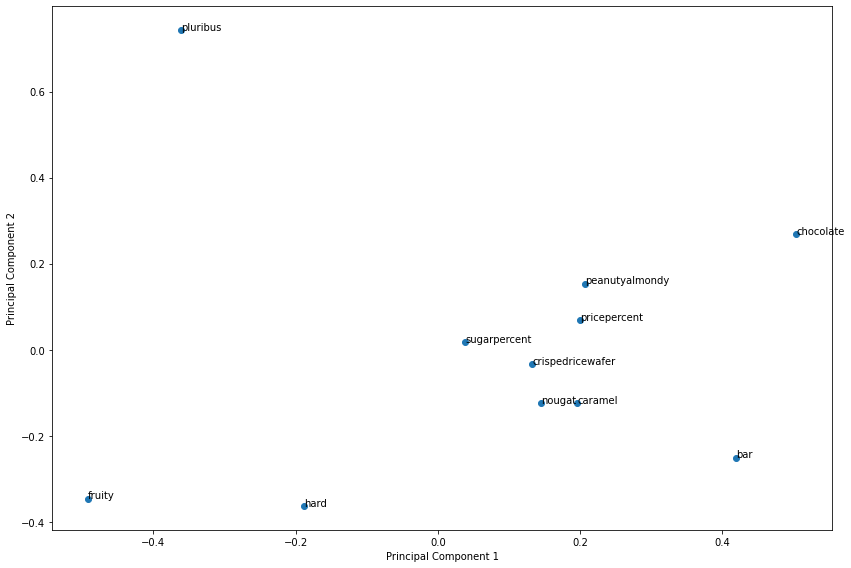

In [43]:
fig = plt.figure(figsize = (12,8))

plt.scatter(pca_df.PC1, pca_df.PC2)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i, txt in enumerate(pca_df.Feature):
    plt.annotate(txt, (pca_df.PC1[i],pca_df.PC2[i]))
plt.tight_layout()

In [44]:
# Tranform the dataset, keep only first two components 
df_pca = pca.transform(X) 
df_pca = df_pca[:, 0:2]

scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_pca)

In [45]:
hopkins_test(pd.DataFrame(df_scaled))

0.9634784981339458

Clusters are statistically significant. 

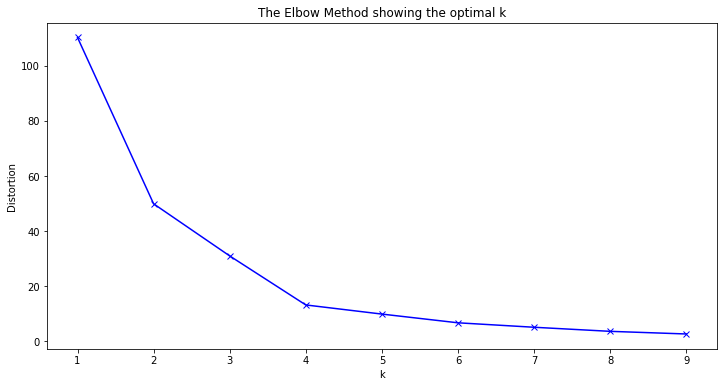

In [46]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(12,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [47]:
kmeanModel = KMeans(n_clusters=4, random_state=42)
kmeanModel.fit(df_scaled)

KMeans(n_clusters=4, random_state=42)

In [48]:
len(kmeanModel.labels_) == 85

True

In [49]:
kmeanModel.labels_

array([2, 2, 2, 2, 1, 2, 2, 3, 3, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0,
       3, 2, 2, 2, 0, 3, 2, 1, 1, 1, 3, 3, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 0, 2, 3, 3, 0, 0, 2, 2, 3, 2, 1, 3, 0, 0, 3, 0, 0, 3, 0, 2, 2,
       0, 0, 0, 0, 3, 2, 1, 0, 1, 2, 3, 2, 0, 2, 1, 1, 0, 1, 3],
      dtype=int32)

In [50]:
# creation of data frame with original features for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df)
dfkm4c = pd.concat([df_dummy, pd.Series(kmeanModel.labels_)], axis=1) # df-dataframe, km-kmeans, 5c-5clusters.
dfkm4c

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,0
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,0.670,2
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,0.676,2
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.323,2
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,0.461,2
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,0.523,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,0.455,1
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,0.390,1
82,Welchs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,0.444,0
83,Werthers Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,0.419,1


In [51]:
dfkm4c.rename(columns={0:'Cluster ID'}, inplace=True)
dfkm4c.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,Cluster ID
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,0.670,2
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,0.676,2
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.323,2
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,0.461,2
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,0.523,1


In [52]:
# creation of data frame with features as principal components for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(pd.DataFrame(df_scaled))
dfpcakm4c = pd.concat([df_dummy, pd.Series(kmeanModel.labels_)], axis=1)
dfpcakm4c.columns = ['PC1', 'PC2', 'Cluster ID']

In [53]:
dfpcakm4c.head()

,PC1,PC2,Cluster ID
0,0.920119,-0.638434,2
1,0.760552,-0.619878,2
2,0.038601,-0.474069,2
3,0.087449,-0.417730,2
4,-0.194699,-1.112814,1


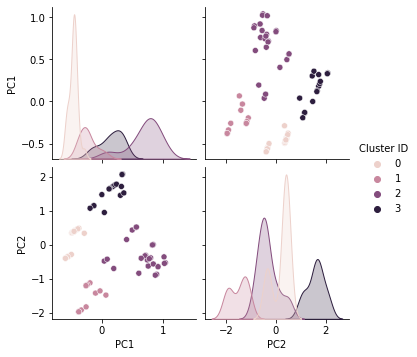

In [54]:
sns.pairplot(data = dfpcakm4c, vars=['PC1', 'PC2'], hue='Cluster ID')

In [55]:
dfkm4c.groupby('Cluster ID').sum()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
Cluster ID,,,,,,,,,,,,
0,0,26,0,0,0,0,8,0,27,13.194,9.381,12.112
1,1,12,2,0,0,0,7,0,0,5.504,3.599,5.369
2,24,0,9,10,7,6,0,21,0,13.577,18.289,16.799
3,12,0,3,4,0,1,0,0,17,8.410,8.586,8.489


* Cluster 1: Box/Pack of fruity candies
* Cluster 2: Fruity candies with caramel 
* Cluster 3: Choco bars with different tasstes
* Cluster 4: Box/Pack of choco candies with different tastes

In [56]:
table = dfkm4c.groupby("Cluster ID").agg({"winpercent": "mean", "pricepercent": "mean", "sugarpercent": "mean"}
                             ).rename(columns={"winpercent" : "average winpercent", 
                                               "pricepercent" : "average pricepercent", 
                                               "sugarpercent" : "average sugarpercent", }
                             ).sort_values("average winpercent", ascending = False)
table

,average winpercent,average pricepercent,average sugarpercent
Cluster ID,,,
2,0.599964,0.653179,0.484893
3,0.499353,0.505059,0.494706
0,0.448593,0.347444,0.488667
1,0.413000,0.276846,0.423385


Text(0, 0.5, 'Percentage')

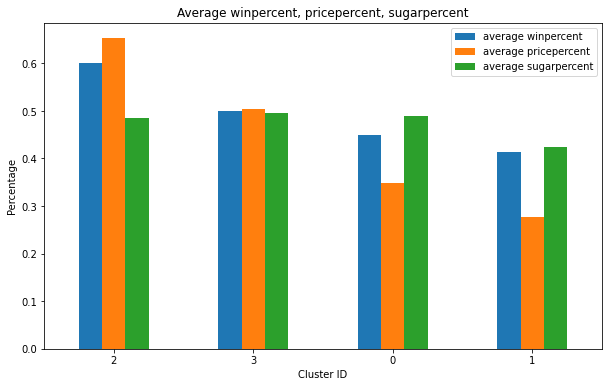

In [57]:
table.plot(kind = "bar", rot = 0.90, legend = True, figsize = [10, 6])
plt.title("Average winpercent, pricepercent, sugarpercent")
plt.xlabel("Cluster ID")
plt.ylabel("Percentage")

## Modelling 

In [58]:
X_train = df.drop(['competitorname', 'winpercent', 'sugarpercent', 'pricepercent'], axis=1)
target = df['winpercent']

In [59]:
import time
#Instantiate the model setting the weights
rfr = RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True)

#Hyperparameters grid to be tuned
param_grid = {
        'n_estimators': [10, 30],
        'max_depth': [2, 5, None], 
}


# we'll use 5-fold cross-validation
rf_grid = GridSearchCV(rfr, param_grid, cv=5, 
                              scoring='neg_mean_squared_error',return_train_score=True, n_jobs=-1)

#Fit the model 
start = time.time()
rf_grid.fit(X_train, target)
end = time.time() - start
print(f"Took {end} seconds")

Took 1.5781044960021973 seconds


In [60]:
rf_grid.best_params_

{'max_depth': 5, 'n_estimators': 10}

In [61]:
np.sqrt(-rf_grid.best_score_)

0.11247295803532953

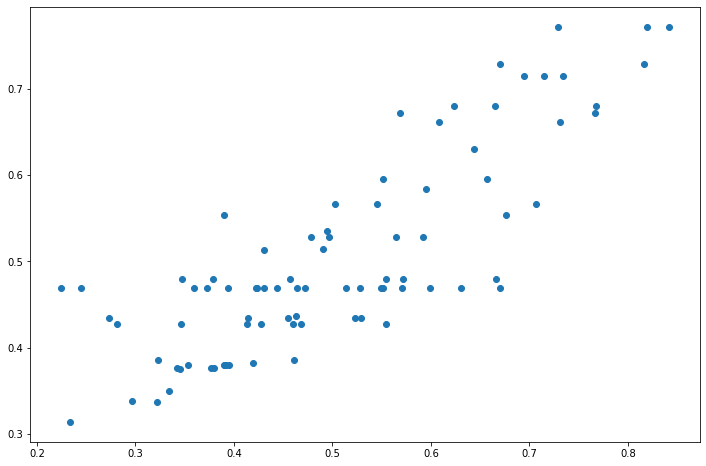

In [62]:
y_pred = rf_grid.predict(X_train)

fig, ax = plt.subplots()
plt.scatter(x=target, y=y_pred, alpha=1)

#Set title and labels for the axis 
plt.title("") 

fig.set_size_inches(12, 8)

In [63]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42, n_jobs=-1, bootstrap=True)
rfr.fit(X_train, target)

RandomForestRegressor(max_depth=5, n_estimators=10, n_jobs=-1, random_state=42)

<AxesSubplot:>

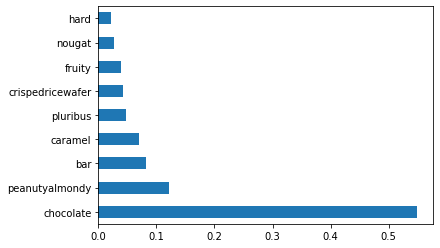

In [64]:
feat_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [65]:
for k, v in sorted(zip(feat_importances, X_train.columns), reverse=True):
    print(f"{v}: {k}")

chocolate: 0.5495422956120739
peanutyalmondy: 0.12173661367694703
bar: 0.081913763648309
caramel: 0.0696368233293193
pluribus: 0.047780793204208756
crispedricewafer: 0.04176577053352297
fruity: 0.03938475471161708
nougat: 0.027019562261178475
hard: 0.021219623022823528
